---
# KT, 지니랩스
---
```
Test 1
data_size = 20 * 50
w,h,c = 32,32,1
batch = 128
epoch = 100
```

In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import shutil
import glob # 특정 폴더에 하위 폴더 및 파일 목록을 다 가져오는 모듈
import cv2

# 경고 뜨지 않게 ..
import warnings
warnings.filterwarnings('ignore')

# 출력한 내용 청소
from IPython.display import clear_output

# 그래프 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['figure.figsize'] = 20, 10
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['text.color'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['xtick.labelcolor'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['ytick.labelcolor'] = 'white'
plt.rcParams['legend.labelcolor'] = 'white'
plt.rcParams['legend.facecolor'] = 'grey'


# 랜덤 모듈
import random

# 학습 모델 저장 및 복원
import pickle

# 딥러닝 라이브러리
import tensorflow as tf
# 신경망 모델을 관리하는 객체
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta

# 선형 회귀 레이어
from tensorflow.keras.layers import Dense
# 활성화 함수를 정의하는 객체
from tensorflow.keras.layers import Activation
# 원핫 인코딩을 수행하는 함수
from tensorflow.keras.utils import to_categorical
# 모델을 자동 저장한다.
from tensorflow.keras.callbacks import ModelCheckpoint
# 성능이 더이상 좋아지지 않을 경우 중단 시킨다.
from tensorflow.keras.callbacks import EarlyStopping
# GPU 사용 확인
from tensorflow.python.client import device_lib
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 표준화
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# 문자열 -> 숫자
from sklearn.preprocessing import LabelEncoder

# 전체데이터를 학습용과 검증으로 나눈다.
from sklearn.model_selection import train_test_split, KFold

# ★매우 중요★
# 현재 프로젝트에서 GPU 메모리 사용을 필요한 만큼만 쓸 수 있도록 한다.
# 컴퓨터에 있는 GPU 정보들을 가져온다.
# gpu가 있다면...

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [2]:
# CNN : 커널을 통해 합성곱을 구하는 것. 이미지의 특징이 두드러 지게 한다.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv1D

# MaxPooling : 커널내에서 가장 큰 값을 추출하는 방식으로 불필요한 부분을 제거한다.
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import MaxPool1D

# Flatten : 다차원의 이미지 데이터를 선형 회귀 은닉층으로 전달하기 전에
# 1차원으로 변환하는 것
from tensorflow.keras.layers import Flatten

# Dropout : 이미지나 영상, 음파 등의 데이터는 오랫동안 학습을 진행 시켜야 한다.
# 하지만 너무 빨리 과적합이 발생되면 조기 중단 때문에 학습 횟수가 줄어들 수 있다.
# 이에 은닉의 노드를 일부 사용하지 않으므로써 과적합이 빨리 오는 것을 예방하고
# 오랫동한 학습이 진행될 수 있도록 한다.
from tensorflow.keras.layers import Dropout

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

def set_tensorflow_config(per_process_gpu_memory_fraction=0.8):
    config = tf.compat.v1.ConfigProto()
    # config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = per_process_gpu_memory_fraction
    config.gpu_options.allow_growth=True
    # sess = tf.Session(config=config)
    sess = tf.compat.v1.Session(config=config)
    
    print("== TensorFlow Config options set ==")
    print("\nThis process will now utilize {} GPU Memeory Fraction".format(per_process_gpu_memory_fraction))

In [3]:
# 이미지 파일을 지정하여 이미지 데이터를 읽어온다.
from PIL import Image

In [4]:
# 하위 폴더 들의 이름을 가져온다(결과 데이터)
categories = list(os.walk('./train/'))[0][1]  # [0] 폴더목록, [0][1] 폴더목록 내 하위폴더

In [5]:
categories

['가자미전',
 '간장게장',
 '감자탕',
 '거봉포도',
 '고구마',
 '고구마맛탕',
 '고등어찌개',
 '곱창구이',
 '군만두',
 '굴전',
 '김치찌개',
 '깻잎나물볶음',
 '꼬리곰탕',
 '꽈리고추무침',
 '나시고랭',
 '누룽지',
 '단무지',
 '달걀말이',
 '달걀볶음밥',
 '달걀비빔밥',
 '닭가슴살',
 '닭개장',
 '닭살채소볶음',
 '닭칼국수',
 '도가니탕',
 '도토리묵',
 '돼지감자',
 '돼지고기구이',
 '두부',
 '두부고추장조림',
 '딸기',
 '떡갈비',
 '떡국',
 '레드와인',
 '마늘쫑무침',
 '마카롱',
 '매운탕',
 '미소된장국',
 '미소장국',
 '미역초무침',
 '바나나우유',
 '바지락조개국',
 '보리밥',
 '불고기',
 '비빔밥',
 '뼈해장국',
 '삼선자장면',
 '새우매운탕',
 '새우볶음밥',
 '생연어']

In [6]:
num_classes = len(categories)

https://lynnshin.tistory.com/27

In [7]:
# image size
image_w = 64
image_h = 64
channel = 3

pixels = image_w * image_h * channel

In [8]:
# Imgdatagen
idg = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         rotation_range=30,
                         zoom_range = 0.1,
                         height_shift_range = 0.1,
                         width_shift_range = 0.1,
                         fill_mode='constant'
                        )                 

In [61]:
X = []
y = []
averArr = np.zeros(shape=(image_w, image_h, channel))

for idx, category in enumerate(categories):
    # one-hot
    label = [0 for i in range(num_classes)]
    label[idx] = 1
    
    image_dir = './train/' + category
    files = glob.glob(image_dir + './*.jpg')
    
    for i, j in enumerate(files):
        # 원본 저장
        img_org = Image.open(j)
        img1 = img_org.resize((image_w, image_h))
        data = np.asarray(img1) / 255
        
        averArr += np.asarray(img_org.resize((image_w, image_h)))
        X.append(data)
        y.append(label)
        
        for k in range(0,4):
            img2 = np.expand_dims(img1, axis = 0)
            datagen = idg.flow(img2)
            aug_img = next(datagen)
            img2 = np.squeeze(aug_img)
            data = np.asarray(img2) / 255

            X.append(data)
            y.append(label)
            
        if i == 199:
            averArr = (np.trunc((averArr / 200))) / 255
            X.append(averArr)
            averArr = np.zeros(shape=(image_w, image_h, channel))
        
    print(category, 'done')
    
X = np.array(X)
y = np.array(y)

가자미전 done
간장게장 done
감자탕 done
거봉포도 done
고구마 done
고구마맛탕 done
고등어찌개 done
곱창구이 done
군만두 done
굴전 done
김치찌개 done
깻잎나물볶음 done
꼬리곰탕 done
꽈리고추무침 done
나시고랭 done
누룽지 done
단무지 done
달걀말이 done
달걀볶음밥 done
달걀비빔밥 done
닭가슴살 done
닭개장 done
닭살채소볶음 done
닭칼국수 done
도가니탕 done
도토리묵 done
돼지감자 done
돼지고기구이 done
두부 done
두부고추장조림 done
딸기 done
떡갈비 done
떡국 done
레드와인 done
마늘쫑무침 done
마카롱 done
매운탕 done
미소된장국 done
미소장국 done
미역초무침 done
바나나우유 done
바지락조개국 done
보리밥 done
불고기 done
비빔밥 done
뼈해장국 done
삼선자장면 done
새우매운탕 done
새우볶음밥 done
생연어 done


In [62]:
X.shape, y.shape

((50050, 64, 64, 3), (50000, 50))

(-0.5, 63.5, 63.5, -0.5)

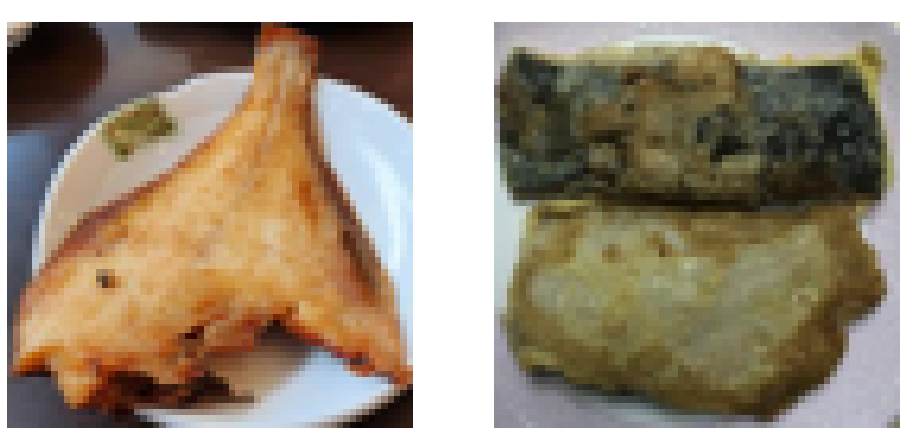

In [63]:
# 사진비교 (평균 필터 전후)
plt.figure(figsize = (16,10))
plt.subplot(121)
plt.title('before')
plt.imshow(X[0])
plt.axis('off')

plt.subplot(122)
plt.title('after')
plt.imshow(X[400])
plt.axis('off')

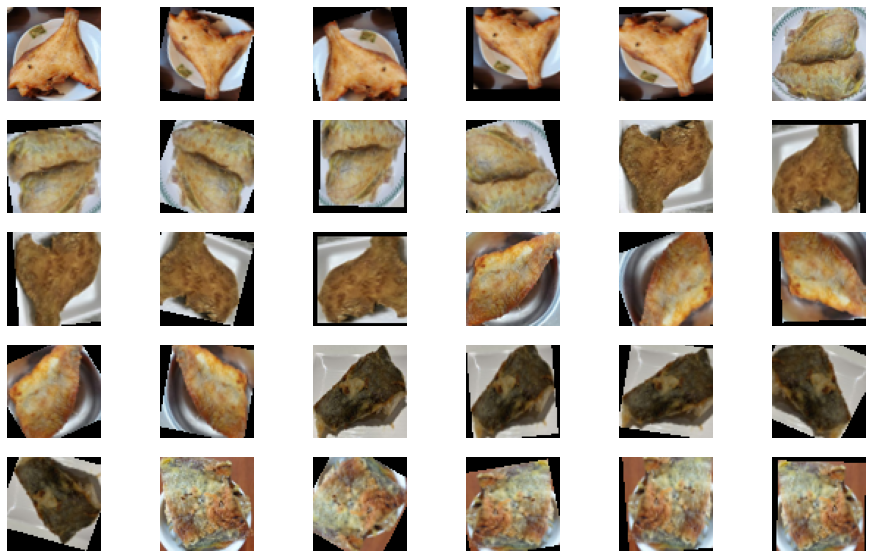

In [64]:
# X 샘플확인 (30개만)
plt.figure(figsize=(16,10))
for g in range(len(X[:30])):
    plt.subplot(5,6,g+1)
    plt.imshow(X[g])
    plt.axis('off')

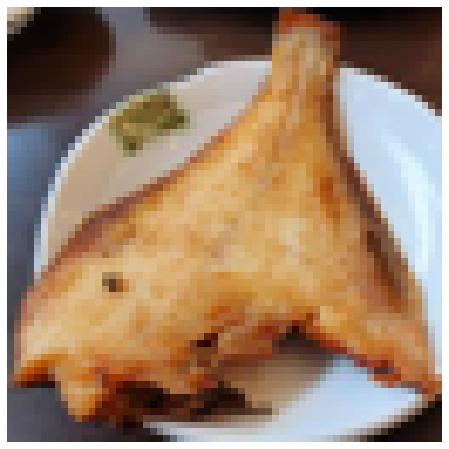

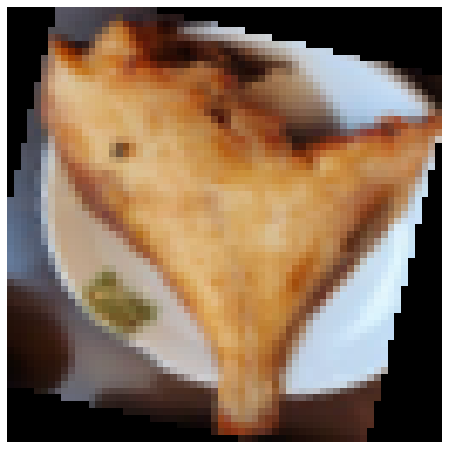

In [65]:
# 사진확인
for dd in range(len(X[:2])):   
    plt.figure(figsize = (8, 8))
    plt.imshow(X[dd])
    plt.axis('off')

In [66]:
# 다중 분류 옵션들
out_nodes = len(categories)
loss_function = 'categorical_crossentropy'
activation_function = 'softmax'

In [67]:
model = Sequential() 

model.add(Conv2D(64, padding='same', kernel_size = (3,3), input_shape = (image_h, image_w, channel)))
model.add(Activation('LeakyReLU'))

model.add(MaxPool2D(pool_size = 2))
model.add(Dropout(0.25))

model.add(Flatten(input_shape= (image_h, image_w, channel)))

model.add(Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.5)) 

model.add(Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.3))

model.add(Dense(num_classes, activation='softmax'))

adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad = False)
model.compile(loss='categorical_crossentropy',
   optimizer = adam,
   metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 65536)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               8388736   
                                                      

In [16]:
# 학습모델을 저장할 경로
path = './model/zero'

```
# 만약 폴더가 있다면 삭제한다.
if os.path.isdir(path) :
    shutil.rmtree(path)
    
# 폴더를 생성한다.
os.makedirs(os.path.join(path))
```

In [17]:
# 모델_체크포인트 문법
path1 = path + '/{epoch}-{val_loss}.h5'
path2 = path + '/best_model.h5'

# 저장 콜백
call1 = ModelCheckpoint(filepath = path1, monitor = 'val_loss', save_best_only = True) # 이미지 작업에선 빼도된다. 용량주의
call2 = ModelCheckpoint(filepath = path2, monitor = 'val_loss', save_best_only = True)

# 조기 중단
call3 = EarlyStopping( monitor = 'val_loss', patience = 50 )

In [18]:
class Dataloader(Sequence):

    def __init__(self, x_set, y_set, batch_size, shuffle=False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)
        
        
    def __getitem__(self, idx):
        indices = self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]

        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [19]:
# folding model_fit
# parameters
kf = KFold(n_splits=5, shuffle=True)
epoch = 100
batch = 256

model_history = [] 

for fold, (train_idx, val_idx) in enumerate(kf.split(y)):
    print("Training on Fold: ", fold + 1)
    X_train, X_test, y_train, y_test = X[train_idx], X[val_idx], y[train_idx], y[val_idx]
    
    # Data loader
    train_loader = Dataloader(X_train, y_train, batch, shuffle=True)
    valid_loader = Dataloader(X_test, y_test, batch)
    test_loader = Dataloader(X_test, y_test, batch)
    
    history = model.fit(train_loader, validation_data = valid_loader, epochs = epoch, workers = 8,
                   callbacks= [call1, call2, call3]
                   )
    
    model_history.append(history)

Training on Fold:  1
Epoch 1/100
63/63 [==============================] - 2s 23ms/step - loss: 4.5563 - accuracy: 0.0347 - val_loss: 3.7006 - val_accuracy: 0.0890
Epoch 2/100
63/63 [==============================] - 1s 21ms/step - loss: 3.8220 - accuracy: 0.0609 - val_loss: 3.5709 - val_accuracy: 0.1145
Epoch 3/100
63/63 [==============================] - 1s 20ms/step - loss: 3.7011 - accuracy: 0.0862 - val_loss: 3.4874 - val_accuracy: 0.1147
Epoch 4/100
63/63 [==============================] - 1s 23ms/step - loss: 3.5984 - accuracy: 0.0988 - val_loss: 3.4077 - val_accuracy: 0.1455
Epoch 5/100
63/63 [==============================] - 2s 26ms/step - loss: 3.5241 - accuracy: 0.1093 - val_loss: 3.3565 - val_accuracy: 0.1643
Epoch 6/100
63/63 [==============================] - 2s 25ms/step - loss: 3.4662 - accuracy: 0.1171 - val_loss: 3.3199 - val_accuracy: 0.1630
Epoch 7/100
63/63 [==============================] - 2s 25ms/step - loss: 3.4088 - accuracy: 0.1315 - val_loss: 3.2731 - val_ac

In [20]:
model_history[0].history

{'loss': [4.556317329406738,
  3.8219797611236572,
  3.7010576725006104,
  3.598386526107788,
  3.5241174697875977,
  3.4662294387817383,
  3.4088070392608643,
  3.379929542541504,
  3.3420538902282715,
  3.305981159210205,
  3.2703447341918945,
  3.2378416061401367,
  3.2247941493988037,
  3.213465929031372,
  3.1847126483917236,
  3.162327766418457,
  3.149519681930542,
  3.1356992721557617,
  3.125770092010498,
  3.120729446411133,
  3.1030478477478027,
  3.0884530544281006,
  3.0840604305267334,
  3.077686071395874,
  3.057061195373535,
  3.0648629665374756,
  3.0414884090423584,
  3.039565086364746,
  3.0222368240356445,
  3.036576986312866,
  3.0114409923553467,
  3.005648136138916,
  3.0006263256073,
  2.995260238647461,
  3.000349283218384,
  2.9877939224243164,
  2.9830236434936523,
  2.9765031337738037,
  2.9716506004333496,
  2.9721779823303223,
  2.966914653778076,
  2.9540488719940186,
  2.95538067817688,
  2.948275327682495,
  2.942215919494629,
  2.943159580230713,
  2.9

In [33]:
len(model_history)

5

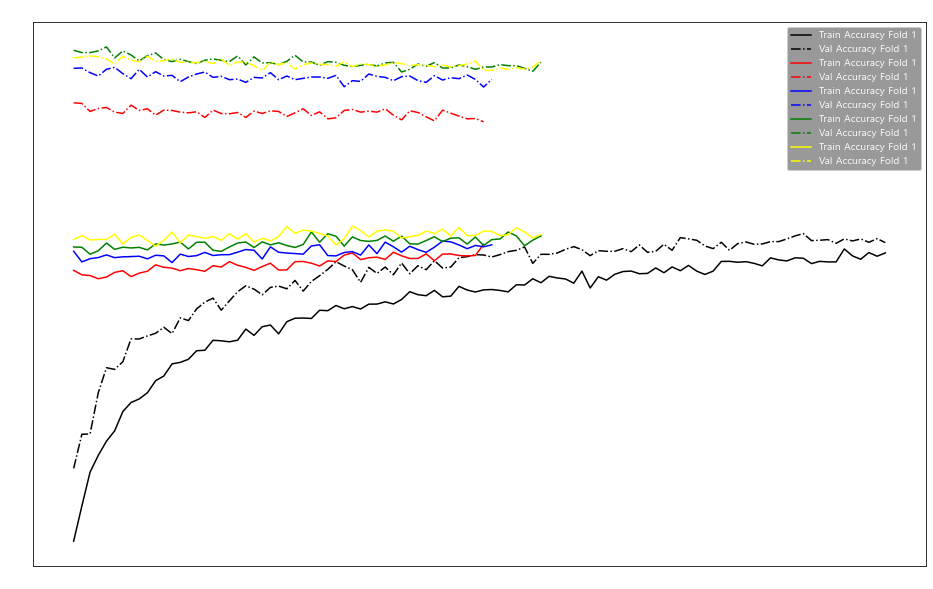

In [35]:
plt.figure(figsize= (16, 10))
plt.title('Train Accuracy vs ValAccuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 1', color='red')
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 1', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 1', color='blue')
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 1', color='blue', linestyle = "dashdot")
plt.plot(model_history[3].history['accuracy'], label='Train Accuracy Fold 1', color='green')
plt.plot(model_history[3].history['val_accuracy'], label='Val Accuracy Fold 1', color='green', linestyle = "dashdot")
plt.plot(model_history[4].history['accuracy'], label='Train Accuracy Fold 1', color='yellow')
plt.plot(model_history[4].history['val_accuracy'], label='Val Accuracy Fold 1', color='yellow', linestyle = "dashdot")
plt.legend()
plt.show()

In [70]:
# 정확도 확인 ( 앞선 결과에 누적되었다 )
a1 = model.evaluate(X_test, y_test)
print(f' 손실률 : {a1[0]}')
print(f' 정확도 : {a1[1]}')

125/125 [==============================] - 1s 6ms/step - loss: 3.9294 - accuracy: 0.0132
 손실률 : 3.9293503761291504
 정확도 : 0.013249999843537807


In [22]:
# 모델 세이브
model.save('./model/one/best_model.h5')

In [36]:
# 리스트를 추출한다.
loss_list = history.history['loss']
accuracy_list = history.history['accuracy']
val_loss_list = history.history['val_loss']
val_accuracy_list = history.history['val_accuracy']

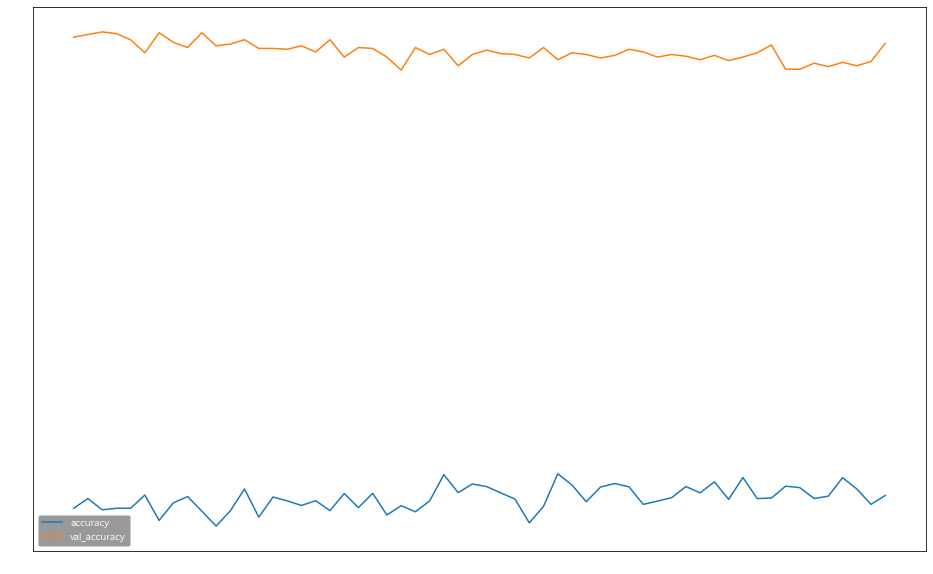

In [37]:
# 정확도 그래프
plt.figure(figsize= (16, 10))
plt.plot(accuracy_list, label='accuracy')
plt.plot(val_accuracy_list, label='val_accuracy')
plt.legend()
plt.show()

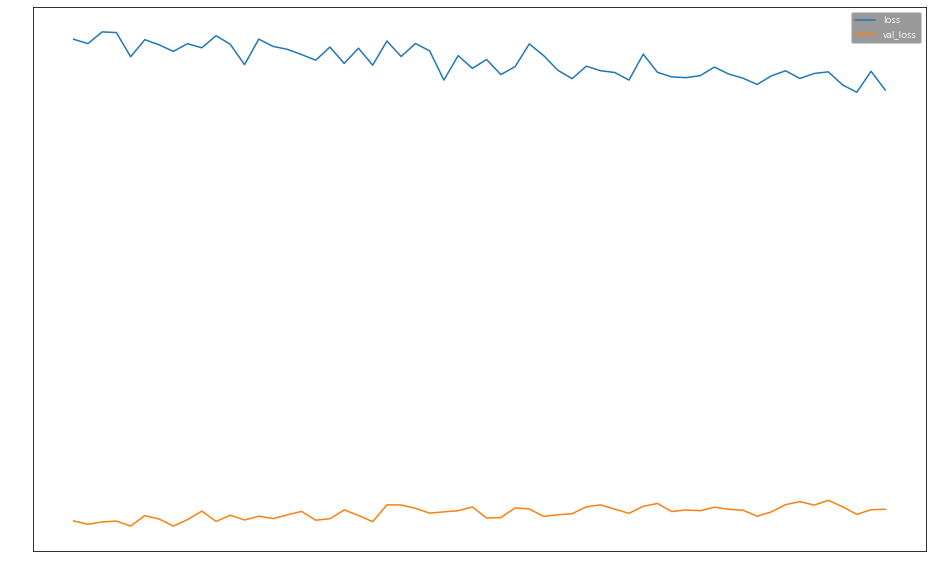

In [38]:
# 손실률
plt.figure(figsize= (16, 10))
plt.plot(loss_list, label='loss')
plt.plot(val_loss_list, label='val_loss')
plt.legend()
plt.show()

# 테스트

# 모델불러오기
from tensorflow.keras.models import load_model
best_model = load_model('./model/zero/best_model.h5')

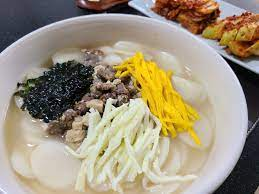

In [85]:
test_org = Image.open('./random_sample/떡국1호.jpg')
test_org

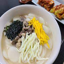

In [86]:
test_img = test_org.resize((image_w, image_h))
test_img

In [87]:
test_data = np.asarray(test_img) / 255

In [88]:
test_data

array([[[0.28235294, 0.27843137, 0.34117647],
        [0.28235294, 0.27843137, 0.34117647],
        [0.2745098 , 0.27058824, 0.33333333],
        ...,
        [0.54117647, 0.58823529, 0.63529412],
        [0.61568627, 0.61176471, 0.65490196],
        [0.69019608, 0.62745098, 0.62745098]],

       [[0.2745098 , 0.27058824, 0.33333333],
        [0.2745098 , 0.27058824, 0.33333333],
        [0.2745098 , 0.27058824, 0.33333333],
        ...,
        [0.55686275, 0.56470588, 0.60784314],
        [0.58823529, 0.57254902, 0.61568627],
        [0.62352941, 0.60392157, 0.65098039]],

       [[0.2745098 , 0.27058824, 0.33333333],
        [0.2745098 , 0.27058824, 0.33333333],
        [0.2745098 , 0.27058824, 0.33333333],
        ...,
        [0.54901961, 0.54117647, 0.59607843],
        [0.54509804, 0.55686275, 0.61568627],
        [0.58039216, 0.57647059, 0.63921569]],

       ...,

       [[0.81176471, 0.81176471, 0.87843137],
        [0.80392157, 0.79215686, 0.85098039],
        [0.81176471, 0

In [89]:
# 텐서로 변환
test_data = tf.reshape(test_data,(1, image_w, image_h, channel))
test_data.shape

TensorShape([1, 64, 64, 3])

In [90]:
# 예측한다.
pred = model.predict(test_data)
pred = pred * 255
pred.astype(int)

1/1 [==============================] - 0s 23ms/step


array([[5, 5, 5, 6, 4, 6, 2, 3, 3, 6, 4, 5, 4, 4, 5, 7, 4, 4, 4, 6, 4, 5,
        8, 4, 5, 4, 5, 6, 3, 5, 7, 3, 6, 4, 5, 4, 4, 4, 5, 5, 4, 4, 5, 4,
        4, 3, 3, 4, 5, 5]])


 predict : 닭살채소볶음 (Category no.22) 



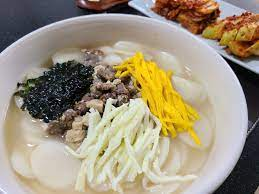

In [91]:
# 답을 출력한다.
print(f'\n predict : {categories[np.argmax(pred)]} (Category no.{np.argmax(pred)}) \n')
test_org